In [37]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
import seaborn as sns
from skimage import exposure, filters, color
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
import warnings
warnings.filterwarnings('ignore')

In [2]:
dir_names=["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]
images=[]
labels=[]

In [3]:
os.chdir('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')

In [82]:
for dir in dir_names:
    os.chdir('./'+dir)
    imgs_names=os.listdir()
    for img_name in imgs_names:
        with Image.open(img_name) as image:
            image=np.array(image)
            images.append(image)
            labels.append(dir)
    os.chdir('../')

<Axes: ylabel='count'>

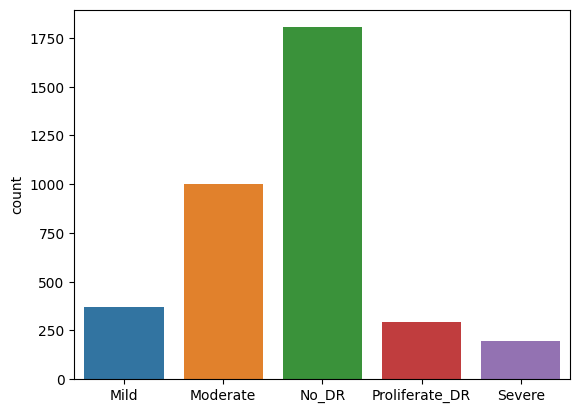

In [5]:
sns.countplot(x=labels)

In [6]:
threshold_per_class = 250
filtered_images = []
filtered_labels = []
class_counts = {label: 0 for label in set(labels)}
for image, label in zip(images, labels):
    if class_counts[label] < threshold_per_class:
        filtered_images.append(image)
        filtered_labels.append(label)
        class_counts[label] += 1

filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)

<Axes: ylabel='count'>

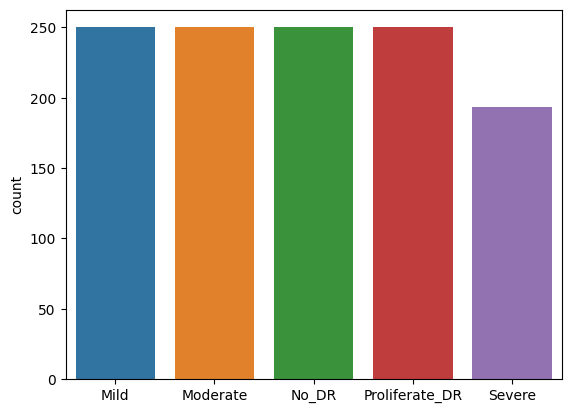

In [7]:
sns.countplot(x=filtered_labels)

In [8]:
len(filtered_images),len(filtered_labels),filtered_images.shape

(1193, 1193, (1193, 224, 224, 3))

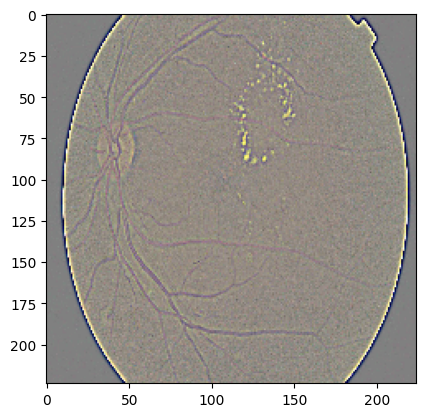

In [83]:
img=filtered_images[55]
plt.imshow(img)

In [84]:
def preprocess_image(image):
#     resized_image = cv2.resize(image, (224, 224))
#     gaussian = cv2.addWeighted(resized_image, 4, cv2.GaussianBlur(resized_image, (0,0), sigmaX), -4, 128)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_l = clahe.apply(l)
    enhanced_lab = cv2.merge((enhanced_l, a, b))
    processed_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    
    return processed_image

(224, 224, 3)


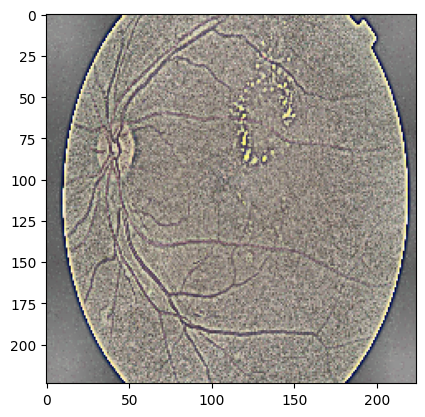

In [85]:
out=preprocess_image(img)
print(out.shape)
plt.imshow(out)

In [86]:
preprocessed_images=[preprocess_image(img) for img in filtered_images]
preprocessed_images=np.array(preprocessed_images)

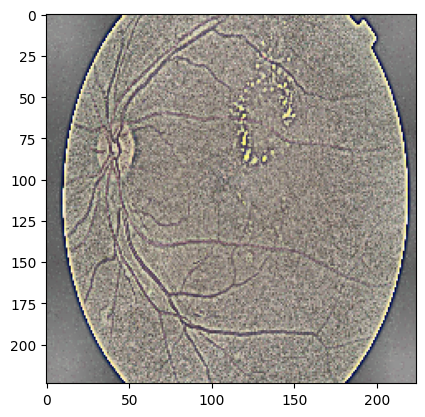

In [88]:
plt.imshow(preprocessed_images[55])

In [89]:
shuffled_indices = np.random.permutation(len(filtered_labels))
shuffled_preprocessed_images = preprocessed_images[shuffled_indices]
shuffled_filtered_labels = filtered_labels[shuffled_indices]

Mild


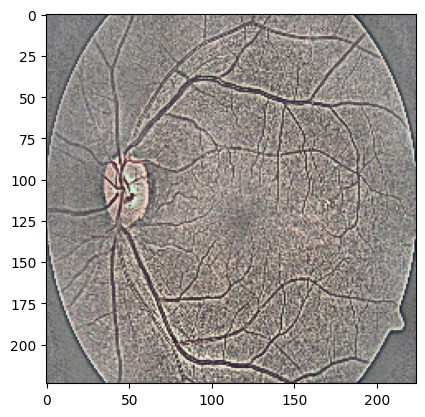

In [91]:
plt.imshow(shuffled_preprocessed_images[5])
print(shuffled_filtered_labels[5])

In [16]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  
    iaa.Affine(rotate=(-10, 10)), 
    iaa.Affine(scale=(0.8, 1.2)) 
])


In [17]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  
    iaa.Affine(rotate=(-10, 10)), 
    iaa.Affine(scale=(0.8, 1.2)) 
])

In [18]:
augmented_images = []
augmented_labels = []

In [19]:
for image, label in zip(shuffled_preprocessed_images, shuffled_filtered_labels):
    augmented_image = seq(image=image)
    augmented_images.append(augmented_image)
    augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

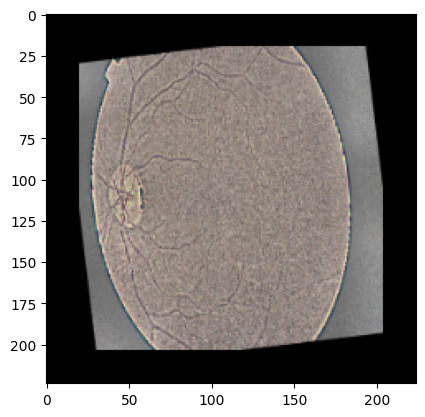

In [20]:
plt.imshow(augmented_images[5])

In [21]:
len(augmented_labels)

1193

In [22]:
final_images = np.concatenate((shuffled_preprocessed_images, augmented_images), axis=0)
final_labels = np.concatenate((shuffled_filtered_labels, augmented_labels), axis=0)

shuffled_indices = np.random.permutation(len(final_labels))
final_images = final_images[shuffled_indices]
final_labels = final_labels[shuffled_indices]

In [23]:
len(final_images)

2386

<Axes: ylabel='count'>

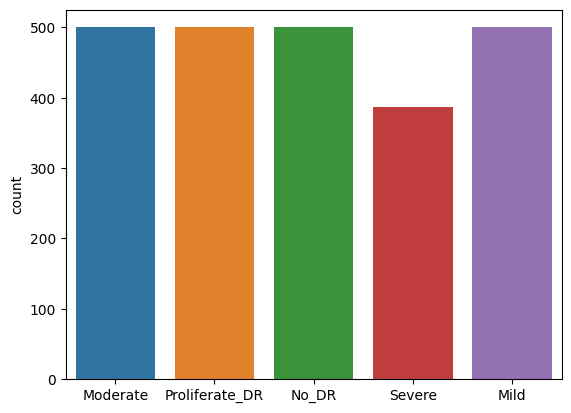

In [24]:
sns.countplot(x=final_labels)

In [25]:
def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title('Label: ' + labels[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

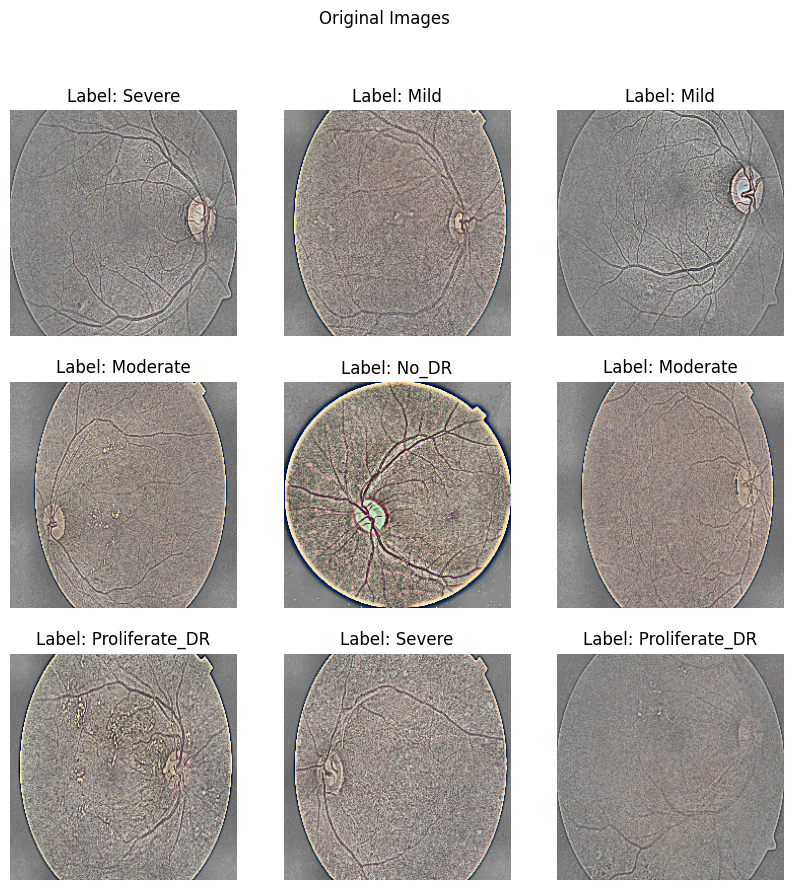

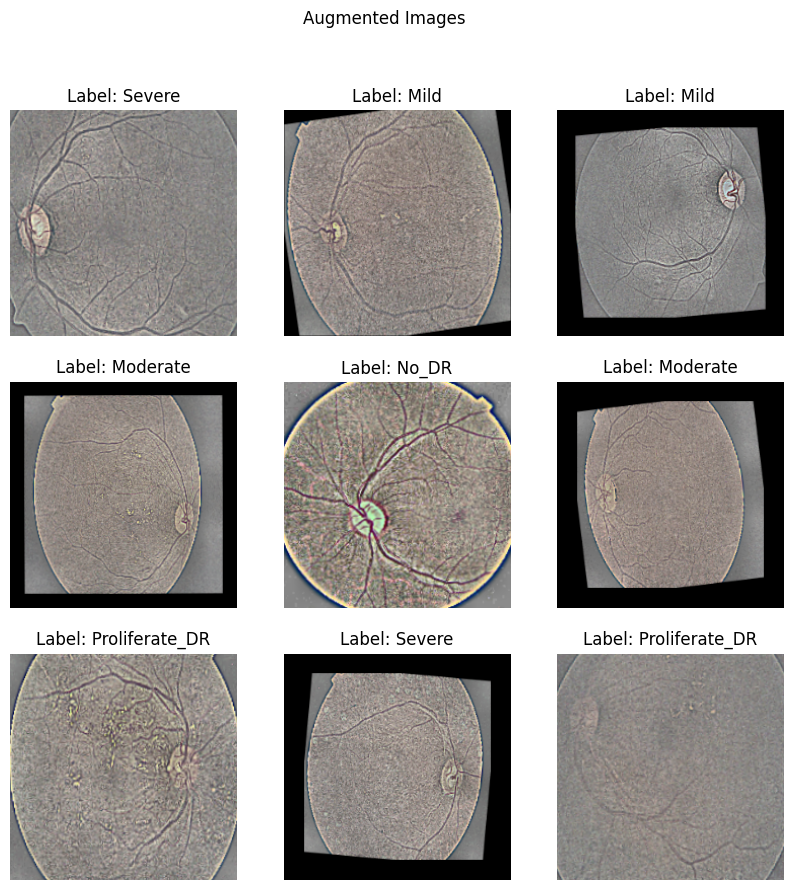

In [26]:
plot_images(shuffled_preprocessed_images[:9], shuffled_filtered_labels[:9], title='Original Images')

plot_images(augmented_images[:9], augmented_labels[:9], title='Augmented Images')

In [43]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

In [44]:
final_labels_encoded=encoder.fit_transform(final_labels)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
x_train,x_test,y_train,y_test=train_test_split(final_images,final_labels_encoded,test_size=.2,stratify=final_labels_encoded)

In [50]:
base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [71]:
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')
])

In [72]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

In [75]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler],batch_size=16)

Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 79s 372ms/step - accuracy: 0.3002 - loss: 1.7452 - val_accuracy: 0.4749 - val_loss: 1.2823 - learning_rate: 0.0010
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4746 - loss: 1.2915 - val_accuracy: 0.5146 - val_loss: 1.1245 - learning_rate: 0.0010
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5137 - loss: 1.1953 - val_accuracy: 0.5586 - val_loss: 1.0462 - learning_rate: 0.0010
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4815 - loss: 1.1982 - val_accuracy: 0.6004 - val_loss: 1.0049 - learning_rate: 0.0010
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5477 - loss: 1.1172 - val_accuracy: 0.5774 - val_loss: 0.9939 - learning_rate: 0.0010
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5442 - loss: 1.1169 - val_accuracy: 0.6109 - val_loss: 0.9596 - learning_rate: 0.0010
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5693 - loss: 

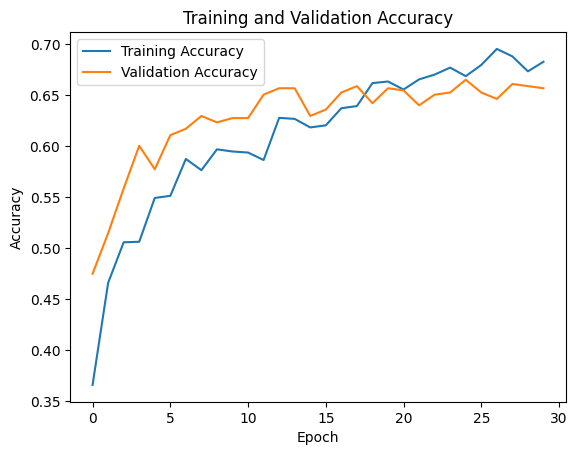

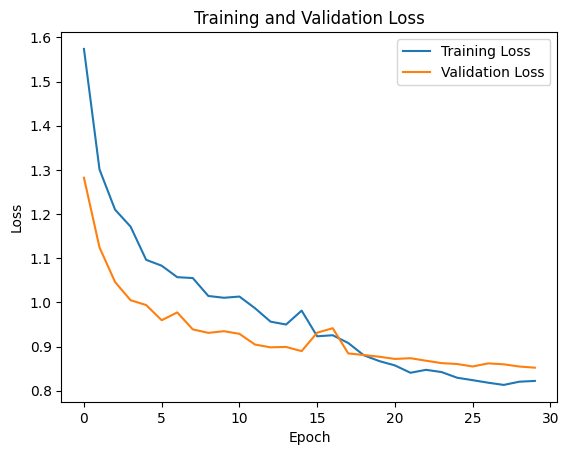

In [76]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


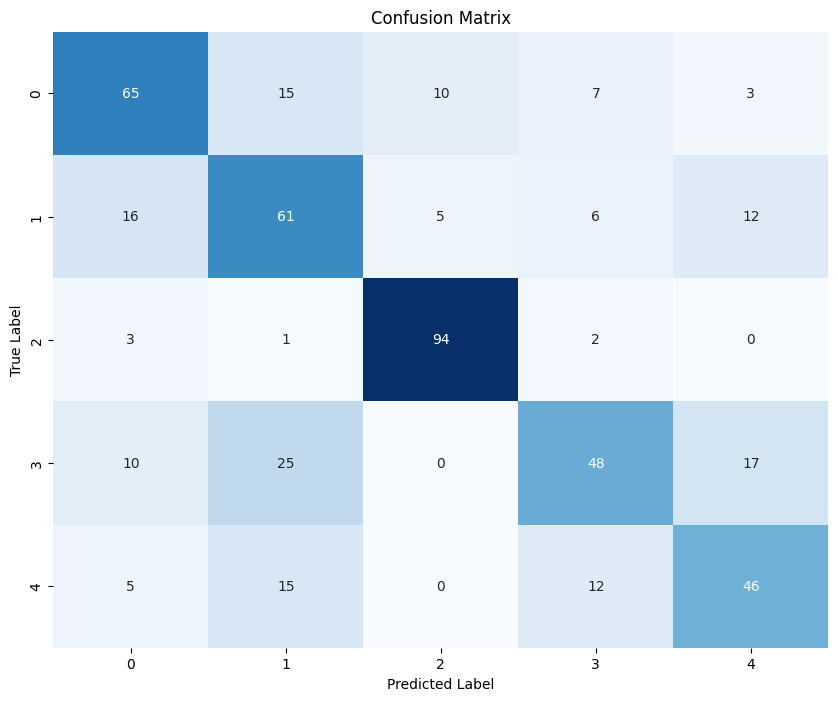

In [81]:
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(x_test)

y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [80]:
model.save('/kaggle/working/my_model.h5')